# SD207 TP2 
# Factorisation de matrices
**WEI Chen**

weichen@whu.edu.cn

Based on Python3.5

Auteurs : Slim Essid, Alexandre Gramfort, Joseph Salmon

Pour ce travail vous devez déposer un **UNIQUE** ﬁchier sous format ipynb sous EOLE. Pour
démarrer un ipython notebook sur les machines de l’école, utiliser la version appelée “(Anaconda)”
dans l’onglet “Applications/développement/”. Le nom du ﬁchier uploadé sera OBLIGATOIREMENT
Nom_Prenom_TP_Clustering.ipynb. Vous devrez charger votre ﬁchier sur Éole (SD207 > TPs > TP1),
et ce avant 23h59, le 01/06/2017. La note totale est sur 20 points répartis comme suit :
 - qualité des réponses aux questions : 15 pts,
 - qualité de rédaction, de présentation et d’orthographe : 2 pts,
 - indentation, Style PEP8 (cf. par exemple https://github.com/ipython/ipython/wiki/Extensions-Index#pep8), commentaires adaptés : 2 pts,
 - absence de bug : 1 pt.
Malus : 5 pts par tranche de 12h de retard (sauf excuses validées par l’administration); 2 pts pour non
respect des autres consignes de rendu. La note sera ensuite ramenée sur 3 points dans la note ﬁnale de
l’UE.
**Rappel : aucun travail par mail accepté**

## 1. Réduction de dimension par analyse en composantes principales (PCA)


### 1.0 Import

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.cm as cm

### 1.1 Import the image of digits manuscrits

In [5]:
digits = load_digits()
X = digits.data
y = digits.target

n_samples, n_features = X.shape
n_digits = len(np.unique(y))

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 10, 	 n_samples 1797, 	 n_features 64


### A faire :
En utilisant sklearn, 
 - afficher la base de données en dimension 2 après réduction de dimension de 64 à 2 avec une PCA ; 
 - colorer les échantillons en fonction des vraies étiquettes ;
 - réaliser un clustering par K-moyennes de la base de données en utilisant les cractéristiques en 2D obtenues par PCA. 
 - comparer au résultat obtenu précédemment sans réduction de dimension.

### 1.2 Dimension reduction from 64 to 2; Display in 2D colored by the true labels

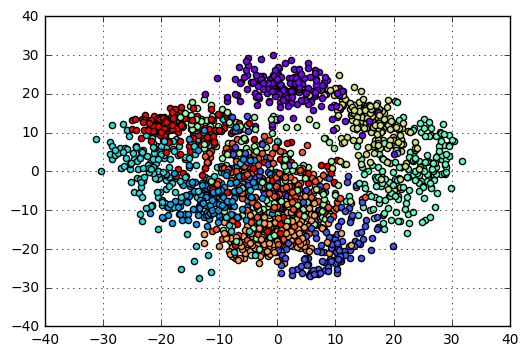

In [34]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X)
# X_2D.shape
colors = cm.rainbow(np.linspace(0, 1, n_digits))
for i in range(n_samples):
    plt.scatter( X_2D[i,0], X_2D[i,1], c = cm.rainbow(np.linspace(0, 1, 10))[y[i]] )
plt.grid()
plt.show()

### 1.3 Clustering by Kmeans

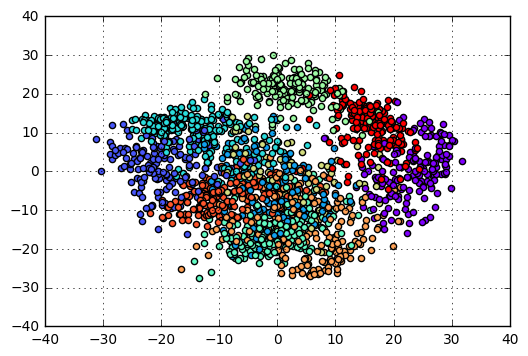

In [32]:
kmeans = KMeans(n_clusters=n_digits, max_iter=1000, random_state=0).fit(X)
y_est = kmeans.labels_
for i in range(n_samples):
    plt.scatter(X_2D[i,0], X_2D[i,1], c=cm.rainbow(np.linspace(0, 1, 10))[y_est[i]])
plt.grid()
plt.show()

## 2. Extraction de caractéristiques faciales

On envisage ici l'utilisation des techniques de décomposition par PCA et NMF pour l'extraction de caractéristiques utiles à la reconnaissance automatique de visages.

 - Étudier et tester le script ci-dessous. 

 - Analyser le type de décomposition obtenu par NMF en comparaison avec celui obtenu par PCA. 


### 2.0 Imports

In [3]:
import numpy as np
from time import time
from numpy.random import RandomState
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### 2.1 Prepare the data and define the utility functions

Dataset consists of 400 faces
2061 negative-valued pixels
2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels


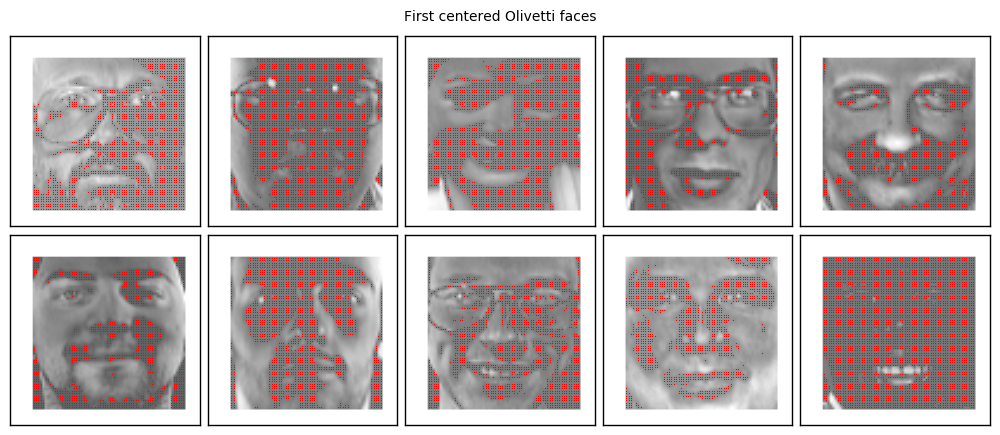

In [7]:
# -- Prepare data and define utility functions 

n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(data_home='c:/tmp/',shuffle=True,
                               random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)

# local centering
# faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

y = dataset.target
X = faces
X_ = faces_centered

print ("Dataset consists of %d faces" % n_samples)

def plot_gallery(title, images):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=10)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)

        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        if len(dmy[0])>0:
            yz, xz = dmy
        comp[comp<0] = 0

        plt.imshow(comp, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)

        if len(dmy[0])>0:
            plt.plot( xz, yz, 'r,', hold=True)
            print (len(dmy[0]), "negative-valued pixels")

        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Plot a sample of the input data
plot_gallery("First centered Olivetti faces",
             faces_centered[:n_components])


### 2.2 The methodes to test and their parameters

In [9]:
# -- Decomposition methods 

# List of the different estimators and whether to center the data

estimators = [
    ('pca', 'Eigenfaces - PCA',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('nmf', 'Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False)
]

### 2.3 Apply the data set of digits images

Extracting the top 10 Eigenfaces - PCA...
done in 1.371s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1883 negative-valued pixels
2221 negative-valued pixels
2127 negative-valued pixels
Extracting the top 10 Non-negative components - NMF...
done in 1.458s


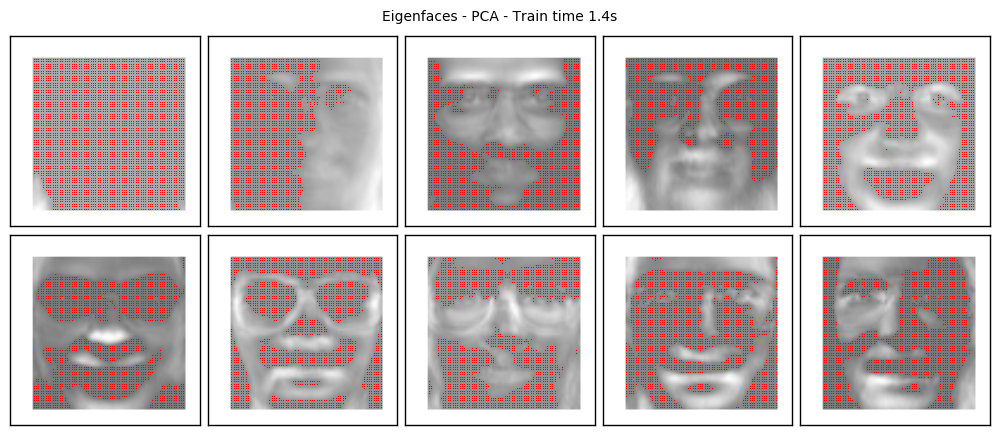

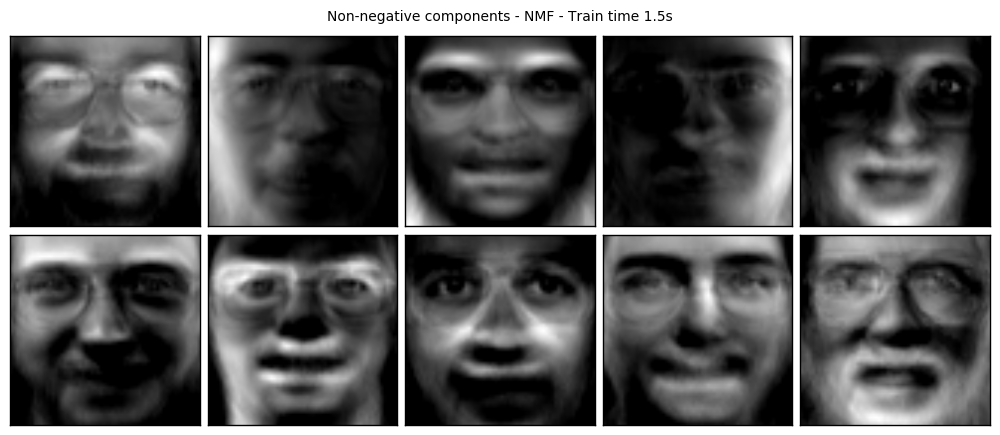

In [10]:
# -- Transform

for shortname, name, estimator, center in estimators:
    #if shortname != 'nmf': continue
    print ("Extracting the top %d %s..." % (n_components, name))
    t0 = time()

    data = X
    if center:
        data = X_

    data = estimator.fit_transform(data)

    train_time = (time() - t0)
    print ("done in %0.3fs" % train_time)

    components_ = estimator.components_

    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

### A faire 

Modifier le script pour réaliser une évaluation des performances d'un système de reconnaissance automatique de visages utilisant les caractéristiques extraites par PCA, comparées à celles obtenues par un système exploitant les caractéristiques extraites par NMF. On pourra utiliser la LDA ou la régression logistique pour la classification. On effectuera l'évaluation par validation croisée. On observera l'évolution des scores en faisant varier le nombre de composantes utilisé dans les décompositions.


### 2.4 Define the dimension reducer (PCA, NMF) and the classifier (Logistic); training the model

In [11]:
pipe = Pipeline(steps=[('reduce_dim', PCA()), ('logistic', LogisticRegression())])

N_FEATURES_OPTIONS = (np.linspace(1, 40, 10)).astype(int)
param_grid = [
    {
        'reduce_dim': [PCA(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
]
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
grid.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'reduce_dim': [PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=40, nls_max_iter=2000, random_state=None, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)], 'reduce_dim__n_components': array([ 1,  5,  9, 14, 18, 22, 27, 31, 35, 40])}],
       pre_dispatch='2*n_jobs', r

### 2.5 Test with varying number of features; Display the results for two dimension reducer

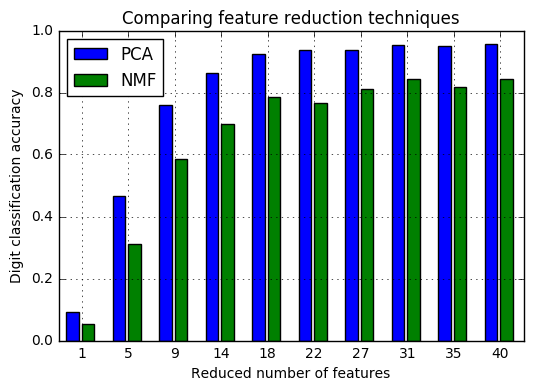

In [12]:
reducer_labels = ['PCA','NMF']
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(reducer_labels), len(N_FEATURES_OPTIONS))
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
#     print(reducer_scores)
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.grid()
plt.legend(loc='upper left')
plt.show()

Generally, the accuracy by using PCA is higher than using NMF. And for both methods, we can see increase of performance with the growing number of featuers used, however the growth becomes slower when the reduced number of features reaches 18. Thus we can could that for the classificaton, the optimal number of features is about 18, which ensures the accuracy and reduces the computation costs.

## 3. Extraction de thèmes à partir de textes

Il s'agit dans cette partie de tester l'utilisation de la NMF pour l'extraction de thèmes à partir d'un corpus de textes ; l'idée principale étant d'interpréter chaque composante NMF extraite comme étant associée à un thème.
<br>
Étudier et tester le script suivant :

### 3.0 Import

In [87]:
from sklearn.feature_extraction import text
from time import time
from sklearn.decomposition import NMF
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

### 3.1 Parameter initialisation

In [3]:
n_samples = 1000
n_features = 900
n_topics = 4
n_top_words = 20

### 3.2 Load the texst in certain categories of corpus [20newsgroups](http://qwone.com/~jason/20Newsgroups/) 

In [4]:
# Load the 20 newsgroups dataset 

t0 = time()

# Load some categories from the training set
categories = ['rec.sport.baseball','comp.graphics', 'comp.sys.mac.hardware',
              'talk.religion.misc']

print ("Loading dataset...")
dataset = datasets.fetch_20newsgroups(data_home='20news-bydate', shuffle=True,
                                      categories=categories, random_state=1, download_if_missing=False)

print ("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 0.781s.


### 3.3 Represent each document by its [TF-IDF](https://fr.wikipedia.org/wiki/TF-IDF) : 

In [5]:
# vectorize data using the most common word
# frequency with TF-IDF weighting (without top 5% stop words)

print ("Extracting TF-IDF features...")
t0 = time()
vectorizer = text.CountVectorizer(max_df=0.95, max_features=n_features, stop_words='english')
counts = vectorizer.fit_transform(dataset.data[:n_samples])
tfidf = text.TfidfTransformer().fit_transform(counts)
print ("done in %0.3fs." % (time() - t0))

Extracting TF-IDF features...
done in 0.417s.


### 3.4 Apply NMF

In [113]:
# Fit the NMF model
print ("Fitting the NMF model with n_samples=%d and n_features=%d..." % (
    n_samples, n_features))

t0 = time()
nmf = NMF(n_components=n_topics).fit(tfidf)
print ("done in %0.3fs." % (time() - t0))

Fitting the NMF model with n_samples=1000 and n_features=900...
done in 0.439s.


Et on interprète les "vecteurs de base" comme des thèmes :

In [114]:
# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print ("By NMF:")
    print ("Topic #%d:" % topic_idx)
    print (" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

By NMF:
Topic #0:
edu year article team baseball cs players writes game university runs host nntp posting jewish good hit season games win
By NMF:
Topic #1:
graphics files file uk thanks ac 3d program package help ca image windows university computer need format posting use com
By NMF:
Topic #2:
com god jesus sandvik people christian writes bible don kent christians brian netcom koresh article life said newton just apple
By NMF:
Topic #3:
mac apple edu drive scsi quadra monitor problem video centris duo se problems card power drives software internal disk ram


La NMF permet donc de réaliser du clustering "doux" de documents : chaque document peut être associé à plusieurs thèmes à la fois.

## A faire

Reproduire l'expérience précédente en utilisant des GMM et en interprétant les thèmes à partir des centroïdes de chaque cluster.
 - Comparer le résultat obtenu au résultat NMF.
 - En interprétant les thèmes au travers des mots clés les plus représentatifs, repérer les thèmes pour lesquels les deux méthodes (NMF et GMM) semblent réaliser un consensus.
 - En étiquettant chaque document par les 3 thèmes les plus pertinents, avec les deux approches, proposer une méthode qui permette de caractériser le "taux d'accord" de ces deux approches quant à l'étiquetage des documents. Calculer ce "taux d'accord".

### 3.5 Apply GMM

In [32]:
# Fit the GMM model
print ("Fitting the GMM model with n_samples=%d and n_features=%d..." % (
    n_samples, n_features))

t0 = time()
gmm = GaussianMixture(n_components=n_topics ).fit(tfidf.toarray() )
print ("done in %0.3fs." % (time() - t0))

Fitting the NMF model with n_samples=1000 and n_features=900...
done in 2.383s.


In [86]:
print("By GMM")
for topic_idx, topic in enumerate(gmm.means_):
    print ("Topic #%d:" % topic_idx)
    print (" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

By GMM
Topic #0:
graphics edu uk university files thanks file com posting help nntp host ac image program 3d ca need use computer
Topic #1:
apple mac edu drive quadra monitor scsi problem com centris duo video card se ram power fpu simms know like
Topic #2:
edu year article team university baseball writes cs players game posting host nntp cleveland runs good hit don season jewish
Topic #3:
com god jesus people edu writes sandvik article christian don bible koresh morality netcom said say does just hp brian


### 3.6 Compare the results between NMF and GMM

In [83]:
similarity=np.zeros([n_topics,n_topics])
for i, topic_nmf in enumerate(nmf.components_):
    for j, topic_gmm in enumerate(gmm.means_):
        topic20_nmf=topic_nmf.argsort()[:-n_top_words - 1:-1]
        topic20_gmm=topic_gmm.argsort()[:-n_top_words - 1:-1]
        similarity[i,j]=len(set(topic20_nmf) & set(topic20_gmm))
print("From the similarity matrix, we compare the top20 key words resulted from both methods and find their correspoding topics.\n")
for i in range(n_topics):
    print ("Topic #%d by NMF correspond to topic #%d by GMM, with %d key words in common." 
           %(i,np.argmax(similarity,1)[i],np.max(similarity,1)[i]))
# print(np.max(similarity,1))
# print(np.argmax(similarity,1))

From the similarity matrix, we compare the top20 key words resulted from both methods and find the correspoding topics.
Topic #0 by NMF correspond to topic #2 by GMM, with 18 key words in common.
Topic #1 by NMF correspond to topic #0 by GMM, with 17 key words in common.
Topic #2 by NMF correspond to topic #3 by GMM, with 15 key words in common.
Topic #3 by NMF correspond to topic #1 by GMM, with 15 key words in common.


Moreover, based on the key words we found, we conclude the four topics in which the two method reach agreeement.

For NMF:

Topic #0 sport, 
Topic #1 graphics, 
Topic #2 religion, 
Topic #3 computer.

For GMM:

Topic #0 graphics, 
Topic #1 computer, 
Topic #2 sport, 
Topic #3 religion.

### 3.7 Agreement rate

#### 3.7.1 Based on the euclidean distance between tfidf and centroids

By NMF and GMM we have obtained the centroids of the fours cluster, and each cluster has been attached a label. In the following, we will classify the text documents based on **the euclidean distance between their tfidf and the centroids**.
$$D_{i,j}=||tfidf_i-C_j||_2$$
where $C_j$ is the j-th centroid.

The **KNN** method will be applied to find the 3 nearest centroids for each document, then 3 most relavant labels will be attached to each document:
$label_{i,j}$ is the j-th most relavant label of document i.

After classifying all the documents for both NMF and GMM, we will define the agreement rate to see the divergence of these two methods. Since **the most relavant label counts more the others**, we put larger weight on it when evaluating the agreement rate. The agreement rate is defined as:

$$A_i=0.8\times 𝟙_{label_{i,1NMF}=label_{i,1GMM}}+0.1\times 𝟙_{label_{i,2NMF}=label_{i,2GMM}}+0.1\times 𝟙_{label_{i,3NMF}=label_{i,3GMM}}$$
$$A=\frac{1}{N}\sum_{i=1}^{N}A_i$$

In [100]:
neigh = NearestNeighbors(3)
neigh.fit(nmf.components_)
labels_nmf = neigh.kneighbors(tfidf.toarray(), return_distance=False)
neigh.fit(gmm.means_)
labels_gmm = neigh.kneighbors(tfidf.toarray(), return_distance=False)

list_nmf=['sport', 'graphics', 'religion', 'computer']
list_gmm=['graphics','computer','sport','religion']
agreement=0

for i in range(n_samples):
    for j in range(3):
        if j==0 and list_nmf[labels_nmf[i,j]]==list_gmm[labels_gmm[i,j]]:
            agreement=agreement+0.8
        if j!=0 and list_nmf[labels_nmf[i,j]]==list_gmm[labels_gmm[i,j]]:   
            agreement=agreement+0.1
print('The agreement rate: ',agreement/n_samples)

The agreement rate:  0.5793000000000115


#### 3.7.1 Based on key words comparison

The classification above takes the whole tfidf into account, and we know that the words with less importance may interfere the classification. So we try to consider only a certain number of key words with more importance in each document, and **compare the similarity between the documents and the centroids based on the number of common key words**. The similarity of document i and centroid j is defined as:
$$S_{i,j}=|\{max_n(tfidf_i)\}\cap \{max_n(C_j)\}|$$
where $C_j$ is the j-th centroid, and n is the number of selected key words. Certainly **the similarity will highly depends on n**. Based on the similarity we selected the 3 most relavant topics for each document. With varying n from 20 to 100, we show the resulted agreement rate between NMF and GMM below.

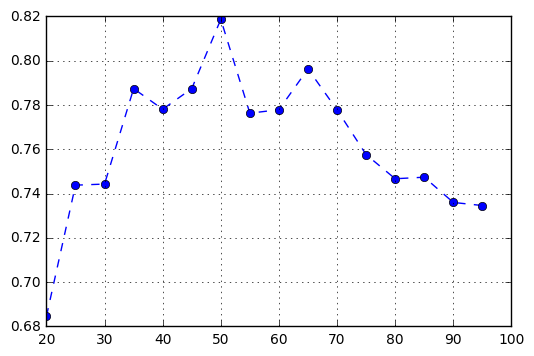

In [134]:
list_nmf = ['sport', 'graphics', 'religion', 'computer']
list_gmm = ['graphics','computer','sport','religion']
similarity = np.zeros([n_samples,n_topics])
A=list()
for n_keywords in range(20,100,5):
    for i, keywords in enumerate(np.argsort(tfidf.toarray())[:,:-n_keywords - 1:-1]):
        for j, topic_nmf in enumerate(np.argsort(nmf.components_)[:,:-n_keywords - 1:-1]):
            similarity[i,j] = len(set(keywords) & set(topic_nmf))
    labels_nmf = np.argsort(similarity,1)[:,:-3-1:-1]

    for i, keywords in enumerate(np.argsort(tfidf.toarray())[:,:-n_keywords - 1:-1]):
        for j, topic_gmm in enumerate(np.argsort(gmm.means_)[:,:-n_keywords - 1:-1]):
            similarity[i,j] = len(set(keywords) & set(topic_gmm))
    labels_gmm = np.argsort(similarity,1)[:,:-3-1:-1]

    agreement = 0
    for i in range(n_samples):
        for j in range(3):
            if j==0 and list_nmf[labels_nmf[i,j]]==list_gmm[labels_gmm[i,j]]:
                agreement = agreement+0.8
            if j!=0 and list_nmf[labels_nmf[i,j]]==list_gmm[labels_gmm[i,j]]:   
                agreement = agreement+0.1
    A.append(agreement/n_samples)

plt.plot(range(20,100,5),A,'--o')
plt.grid()
plt.show()